# How Anxcor uses XArray to simplify timeseries operations. 
## Part II.  Basic Signal Processing

```Anxcor```'s basis in ```XArray.DataArray```s allows it to perform signal processing routines in a very concise, expressive manner. Starting with the conversion process from last tutorial, we'll apply three basic processing routines to our seismic signals: resample, demean & detrend, taper, and bandpass filter.

In [1]:
from anxcor.xarray_routines import XArrayConverter, XArrayResample, \
XArrayRemoveMeanTrend, XArrayBandpass, XArrayTaper

### Test Data Acquisition

Ambient Noise Cross-Correlation is fun, and Christmas is fun, so lets get 1 hour of data from a station in Utah over Christmas day, 2018. I'll apply a filter with low frequency corners of 0.03 and 0.05, and high frequency corners of 40, and 45 hz. Tapering prior to response removal is also important to avoid edge effects, especially when one is working towards cross correlations. And finally, I'll add in the necessary keyword-arguments to return the data in units of displacement (meters).

Normally, this can all be done with the ```remove_response()``` function of the ```Stream``` object. However, ```ObsPy``` is not updated to work with numpy 1.17, and numpy 1.17 or greater is a *strict dependency* of ```Anxcor```. To get around this, anxcor has its own ```remove_response()``` routine included. 

In [2]:
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from anxcor.anxcor_utils import remove_response
client = Client("IRIS")
t  = UTCDateTime("2018-12-25 12:00:00").timestamp
st = client.get_waveforms("UU", "SPU", "*", "H*", t, t + 60*60,attach_response=True)
st.detrend(type='linear')
st.detrend(type='constant')
st.taper(0.05)
pre_filt = (0.03, 0.05, 40.0, 45.0)
st=remove_response(st, output='DISP', pre_filt=pre_filt)
st

/anaconda3/envs/anxcor_dev/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)
/anaconda3/envs/anxcor_dev/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


3 Trace(s) in Stream:
UU.SPU.01.HHE | 2018-12-25T12:00:00.000000Z - 2018-12-25T13:00:00.000000Z | 100.0 Hz, 360001 samples
UU.SPU.01.HHN | 2018-12-25T12:00:00.000000Z - 2018-12-25T13:00:00.000000Z | 100.0 Hz, 360001 samples
UU.SPU.01.HHZ | 2018-12-25T12:00:00.000000Z - 2018-12-25T13:00:00.000000Z | 100.0 Hz, 360001 samples

Lets take a look at the stream 

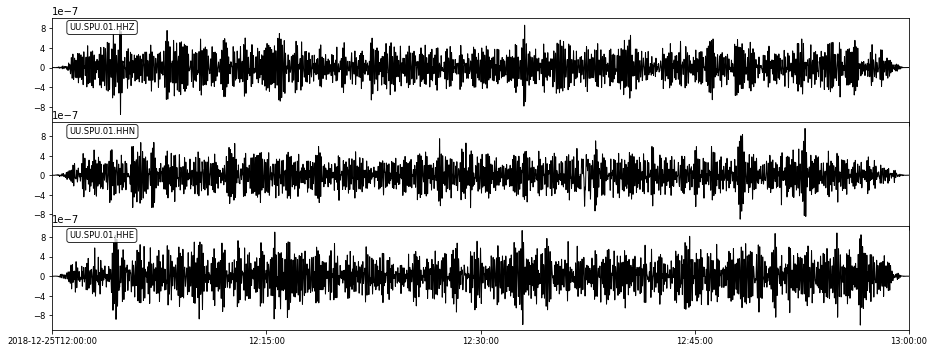

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
fig=plt.figure(figsize=(14,5))
st.plot(fig=fig)
plt.show()

### Convert to DataArray
The units of the y axis are in meters, so we seem to have noise on the order of a few $0.1\mu m$'s. It also looks like obspy automatically tapered the signals. 

Since every trace in the signal:
* has the same sampling rate (100 Hz)
* has the same starttime (2018-12-25T12:00:00.000000)
* has the exact same duration and number of points (6hrs, 216001 samples)
* is from the same station UU.SPU.*

It is safe to let ```Anxcor``` attempt to convert these to an ```xarray.DataArray```.

In [4]:
converter = XArrayConverter()
xarray    = converter(st)
xarray

<xarray.DataArray 'default' (channel: 3, station_id: 1, time: 360001)>
array([[[-1.29549830e-09, -1.29658133e-09, -1.29765895e-09, ...,
         -5.93777230e-13, -1.00343565e-12, -1.41164604e-12]],

       [[-1.21809934e-10, -1.24817509e-10, -1.27829292e-10, ...,
          2.11987588e-10,  2.11123926e-10,  2.10260981e-10]],

       [[-2.04939578e-11, -2.05685935e-11, -2.06431249e-11, ...,
         -3.25319939e-11, -3.25394700e-11, -3.25468591e-11]]])
Coordinates:
  * channel     (channel) <U3 'HHE' 'HHN' 'HHZ'
  * station_id  (station_id) <U6 'UU.SPU'
  * time        (time) datetime64[ns] 2018-12-25T12:00:00 ... 2018-12-25T13:00:00.010000
Attributes:
    delta:       0.01
    starttime:   0
    operations:  xconvert

### Resampling
All the coordinate and metadata matches the traces above, so lets proceed to our first signal processing routine, resampling. Anxcor provides the ```XArrayResample``` utility for this purpose.

Resampling is not a simple interpolation process, but performs the following steps in sequence:
* demeaning: array - array.mean()
* detrend: array - scipy.detrend(array)
* taper
* lowpass filter: lowpass array with corner starting at nyquist of target sampling rate
* linear interpolation

In [5]:
resampler       = XArrayResample()
resampled_array = resampler(xarray)
resampled_array

<xarray.DataArray 'default' (channel: 3, station_id: 1, time: 36001)>
array([[[-1.05112981e-14, -1.43834922e-14, -1.95714129e-14, ...,
          4.74946364e-16,  2.31531920e-16,  2.16624395e-17]],

       [[-3.26895377e-15, -4.47492616e-15, -6.11268567e-15, ...,
          3.02668293e-15,  1.48385456e-15,  1.38954623e-16]],

       [[-2.06758081e-16, -2.82956523e-16, -3.85449607e-16, ...,
         -3.28534548e-16, -1.61460750e-16, -1.51257232e-17]]])
Coordinates:
  * channel     (channel) <U3 'HHE' 'HHN' 'HHZ'
  * station_id  (station_id) <U6 'UU.SPU'
  * time        (time) datetime64[ns] 2018-12-25T12:00:00 ... 2018-12-25T13:00:00
Attributes:
    delta:       0.1
    starttime:   0
    operations:  xconvert->:resampled@10.0Hz

```Anxcor```s ```XArrayProcessing``` routines automatically update the metadata after processing. Here, the resampling routine we applied changed the sampling rate from 100 Hz to 10 Hz, and updated the delta attribute accordingly.

We can also see an additional string has been appended to the 'operations' attribute.

In [6]:
print(resampled_array.attrs['operations'])

xconvert->:resampled@10.0Hz


/anaconda3/envs/anxcor_dev/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


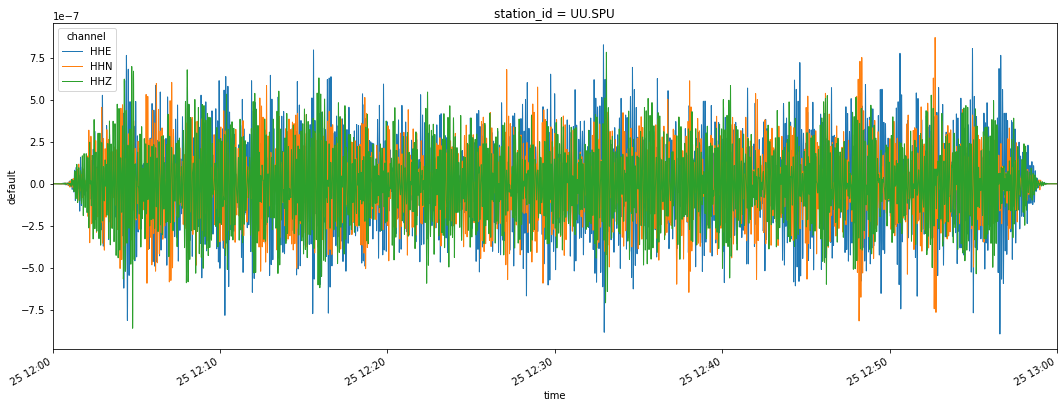

In [7]:
import numpy as np
xarray_squeezed = resampled_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

Its hard to tell if the resampling was successful, so lets resample from the original data down to 0.1 Hz. Let's also tell the resampling method to apply a taper of five percent to both sides of the window

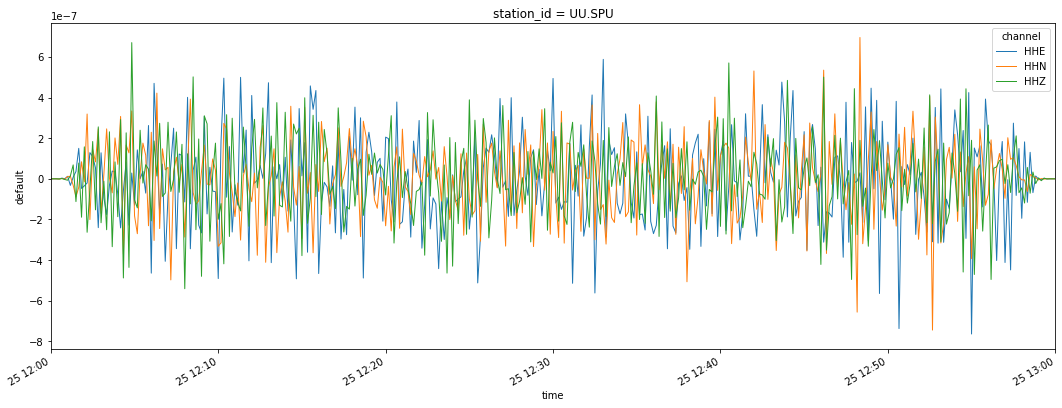

In [8]:
resampler       = XArrayResample(target_rate=0.1,taper=0.05)
resampled_array = resampler(xarray)
xarray_squeezed = resampled_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

Let's print out the attributes again to ensure our processing routines have performed as expected

In [9]:
print(resampled_array.attrs['operations'])
print('\nnumber of points on time axis is: {}'.format(resampled_array.data.shape[-1]))

xconvert->:resampled@0.1Hz

number of points on time axis is: 361


### Remove Mean & Trend

The linear interpolation and low pass filter of the resample routine may introduce a mean and trend to the signal, which will add a dc shift to any resulting crosscorrelations. To combat this, we'll remove the mean and trend. ```Anxcor```'s ```XArrayRemoveMeanTrend``` is expressly for this purpose

In [10]:
remove_mean_trend = XArrayRemoveMeanTrend()
rm_mean_trend_array = remove_mean_trend(resampled_array)
print(rm_mean_trend_array.attrs['operations'])

xconvert->:resampled@0.1Hz->:remove_Mean&Trend


Comparing the sum's along the time axis of both the rm_mean_trend_array and the resampled_array can tell us how successful this operation is

In [11]:
print('channel names                  {}'.format(list(resampled_array.coords['channel'].values)))
print('cumsum of resampled_array:     {}'.format(np.cumsum(resampled_array.data,axis=-1)[:,0,-1]))
print('cumsum of rm_mean_trend_array: {}'.format(np.cumsum(rm_mean_trend_array.data,axis=-1)[:,0,-1]))

channel names                  ['HHE', 'HHN', 'HHZ']
cumsum of resampled_array:     [-1.79561483e-06  1.29713573e-06  1.39759301e-06]
cumsum of rm_mean_trend_array: [-9.27062672e-22 -4.46677531e-23  5.35392651e-22]


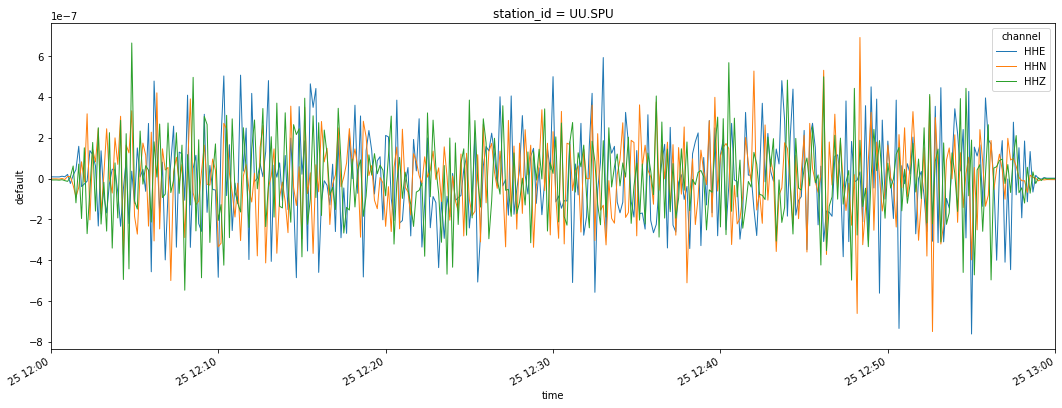

In [12]:
xarray_squeezed = rm_mean_trend_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

### Bandpass

Bandpassing can help remove both low frequency and high frequency energy depending on our needs. ```Anxcor```'s ```XArrayBandpass``` is used for this purpose, and has been designed to operate identically to ```ObsPy```.

Lets redo the above steps with our initial 10Hz resampling rate, but bandpass the series between 3Hz and 0.03Hz. lets also use a 5% taper for the resampling step and using ```XArrayTaper``` for the tapering prior to bandpassing.

In [13]:
resampler       = XArrayResample(target_rate=10,taper=0.05)
remove_meaner   = XArrayRemoveMeanTrend()
bandpasser      = XArrayBandpass(freqmax=3.0,freqmin=0.03)
taperer         = XArrayTaper(taper=0.05)

resampled_array = resampler(xarray)
rm_trend_array  = remove_meaner(resampled_array)
tapered_array   = taperer(rm_trend_array)
bandpassed_array= bandpasser(tapered_array)
print(bandpassed_array.attrs['operations'])

xconvert->:resampled@10Hz->:remove_Mean&Trend->:taper@5.0%->:bandpass@0.03<x(t)<3.0


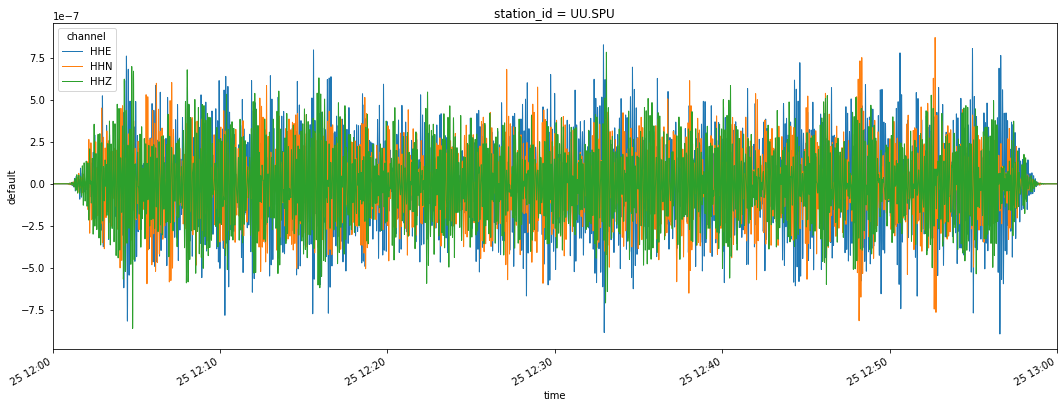

In [14]:
xarray_squeezed = bandpassed_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

If our operations worked correctly, we should have three traces with low frequencies beyond 3 and below 0.03 Hz. Lets use scipy's fftpack to look at the power spectrum. We'll also plot the original amplitude spetrum prior to all the processing.

In [15]:
from scipy import fftpack
bandpassed_data = bandpassed_array.data.squeeze()

target_length   = fftpack.next_fast_len(bandpassed_data.shape[-1])
frequencies     = fftpack.fftshift(fftpack.fftfreq(target_length, d=bandpassed_array.attrs['delta']))

fft_spectrum    = fftpack.fftshift(fftpack.fft(bandpassed_data,target_length,axis=-1))
amplitude_spectrum  = np.abs(fft_spectrum)

original_data   = xarray.data.squeeze()

target_length   = fftpack.next_fast_len(original_data.shape[-1])
frequencies_orig= fftpack.fftshift(fftpack.fftfreq(target_length,d=xarray.attrs['delta']))

orig_amplitude_spec = np.abs(fftpack.fftshift(fftpack.fft(original_data,target_length)))


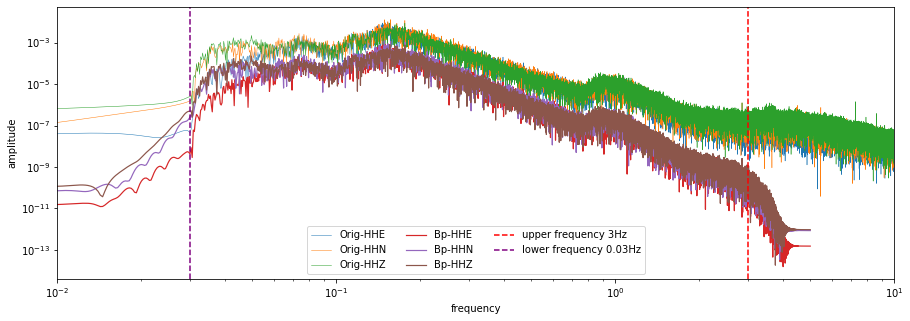

In [21]:
plt.figure(figsize=(15,5))
plt.loglog(frequencies_orig,orig_amplitude_spec[0,:],label='Orig-HHE',linewidth=0.5)
plt.loglog(frequencies_orig,orig_amplitude_spec[1,:],label='Orig-HHN',linewidth=0.5)
plt.loglog(frequencies_orig,orig_amplitude_spec[2,:],label='Orig-HHZ',linewidth=0.5)

plt.loglog(frequencies,amplitude_spectrum[0,:],label='Bp-HHE',linewidth=1.2)
plt.loglog(frequencies,amplitude_spectrum[1,:],label='Bp-HHN',linewidth=1.2)
plt.loglog(frequencies,amplitude_spectrum[2,:],label='Bp-HHZ',linewidth=1.2)

plt.axvline([3.0],label='upper frequency 3Hz',    color='red',linestyle='--')
plt.axvline([0.03],label='lower frequency 0.03Hz',color='purple',linestyle='--')
plt.xlim([1e-2,1e1])
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.legend(ncol=3,loc='lower center')
plt.show()

Compared to the original, the final spectrum's power is a bit lower, but otherwise mirrors the spectrum of the original data. In the next section we'll look at some more complicated signal processing techniques provided by ```Anxcor```.